In this assignment the goal is to implement the dimensionality reduction technique *Principal Component Analysis (PCA)* to a very high dimensional data and apply visualization. Note that you are not allowed to use the built-in PCA API provided by the sklearn library. Instead you will be implementing from the scratch.

    For this task we use the MNIST dataset. First we download the dataset using openml api

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', cache=False)
X = mnist.data
y = mnist.target
print(X.shape, y.shape)

(70000, 784) (70000,)


# Part-1: Preprocessing
Before implementing PCA you are required to perform some preprocessing steps:
1. Mean normalization: Replace each feature/attribute, $x_{ji}$ with $x_j - \mu_j$, In other words, determine the mean of each feature set, and then for each feature subtract the mean from the value, so we re-scale the mean to be 0 
2. Feature scaling: If features have very different scales then scale make them comparable by altering the scale, so they all have a comparable range of values e.g. $x_{ji}$ is set to $(x_j - \mu_j) / s_j$  Where $s_j$ is some measure of the range, so could be  $\max(x_j) - \min(x_j)$ or Standard deviation $stddev(x_j)$.

In [2]:
# mean normalization 
u=X.mean(axis=0)
X=X[:,0:]-u
# feature scaling
X_max_min=X.max(axis=0)-X.min(axis=0)
X_max_min[X_max_min==0]=1
X_scale=X/X_max_min
X_scale


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Part-2: Covariance matrix
Now the preprocessing is finished. Next, as explained in the lecture, you need to compute the covariance matrix https://en.wikipedia.org/wiki/Covariance_matrix. Given $n \times m$ $n$ rows and $m$ columns matrix, a covariance matrix is an $n \times n$ matrix given as below (sigma)
$\Sigma = \frac{1}{m}\sum{\left(x^{i}\right)\times \left(x^{i}\right)^{T}}$
You may use the "numpy.cov" function in numpy library 

In [3]:
#TODO Compute X to covariance matrix cov_matrix.
cov_matrix=np.cov(X_scale,rowvar=False)
cov_matrix.shape

(784, 784)

# Instructions for part 3, 4, and 5
- getSVD() function is expected to return 3 values. For example: ```U, S, V = getSVD(cov_matrix)```
- You can follow the skeleton below to have an idea on how the autograder's test calls your functions:
```
U, S, V = getSVD(cov_matrix)
z = getKComponents(U, X, k)
ratio = getVarianceRatio(z, U, X, k)
```
- Using the built-in PCA implementation in sklearn, the approximate X matrix can be obtained by function ```inverse_transform```

# Part-3: SVD computation
Now compute the SVD on the covariance matrix $SVD(\Sigma)$. You may use the svd implementation in numpy.linalg.svd

In [4]:
def getSVD(cov_matrix):
    U, S, V = np.linalg.svd(cov_matrix,  full_matrices=False)
    return U,S,V

# Part-4: Compute PCA matrix (K dimensional)
Now select the first $k$ columns from the matrix $U$ and multiply with $X$ to get $k$ dimensional representation.

In [5]:
K=5
def getKComponents(U, X, K):
    #TODO implement matrix multiplication of first k columns of U * X
    return np.matmul(X,U[:,:K])
U,S,V=getSVD(cov_matrix)
z=getKComponents(U, X_scale, K)
print(z.shape)

(70000, 5)


# Part-5: Compute Reconstruction Error
Implement a function to compute the variance ratio (from reconstruction error)

In [6]:
def getVarianceRatio(z, U, X, K):
    #Implement computation of reconstruction error        
    U_reduce=U[:,:K]    
    X_approx=z@U_reduce.T   
    numer=np.sum((X-X_approx).T@(X-X_approx))
    Denom=np.sum(X.T@X)
    
    return numer/Denom
getVarianceRatio(z, U, X_scale, K)

0.15997751289570666

Compare the variance ration to the built-in PCA implementation in sklearn https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html (this step is optional)

# Part-6: Scatter plot 2-dimensional PCA
Using matplotlib plot the 2-dimensional scatter plot of the first 2 compoenents with y (target) as labels

<function matplotlib.pyplot.show(*args, **kw)>

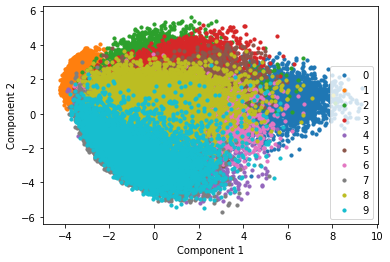

In [7]:
z=getKComponents(U,X_scale, 2)
target = np.unique(y)
for idx, t in enumerate(target):
        sub_z = z[y == t]
        plt.scatter(sub_z[:, 0], sub_z[:, 1], s = 10, label = t )

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc = 'lower right')
plt.show

# Part-7 Find best $K$
Find the minimum value of $K$ with which the ratio between averaged squared projection error with total variation in data is less than 10% in other words we retain 90% of the variance. You can achieve this by repeating getKComponents with $K=1$ until the variance ratio is <= 10%.

In [8]:
for i in range(1,784):
    pca_result_50=getKComponents(U,X_scale,i)
    ratio=getVarianceRatio(pca_result_50,U,X_scale,i)
    if ratio<=0.1:
        print('Best K is: ',i)
        print('Error ratio is: ',ratio)
        break

Best K is:  9
Error ratio is:  0.04792267544723892


# Part-8: TSNE visualization
Finally, having found an optimal $K$ use these components as an input data to another dimensionality reduction method called tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) and reduce it to 2 dimensions.

In [16]:
from sklearn.manifold import TSNE

rndperm = np.random.permutation(mnist.data.shape[0])
pca_result=getKComponents(U,X_scale,100)
#pca_result=pca_result.T
n_sne = 10000 #it is sufficient if done for 10k samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result[:n_sne])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.144s...
[t-SNE] Computed neighbors for 10000 samples in 50.638s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.028561
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.477623
[t-SNE] KL divergence after 300 iterations: 2.772450


Finally, scatter plot the components given by the tSNE using matplotlib compare it to the earlier scatter plot.

<function matplotlib.pyplot.show(*args, **kw)>

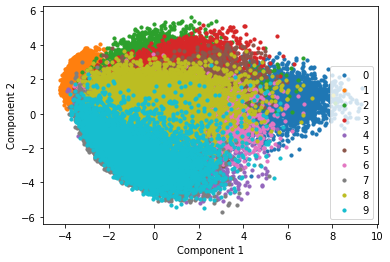

In [19]:
target = y[:n_sne]
for idx, t in enumerate(np.unique(target)):
        sub_z = pca_result[y == t]
        plt.scatter(sub_z[:, 0], sub_z[:, 1], s = 10, label = t )

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc = 'lower right')
plt.show